In [1]:
%cd ..

/home/eli/AnacondaProjects/epych


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import collections
import glob
import functools
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import quantities as pq

import epych
from epych.statistics import alignment, grand

In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
CONDITIONS = ["go_gloexp", "go_seqctl", "lo_gloexp", "lonaive", "lo_rndctl", "igo_seqctl"]
PRETRIAL_SECONDS = 0.5
POSTTRIAL_SECONDS = 0.5

In [7]:
NWB_SUBJECTS = glob.glob('/mnt/data/000253/sub-*/')

In [8]:
PILOT_FILES = []

In [9]:
aligner = epych.statistics.alignment.AlignmentSummary.unpickle("/mnt/data/000253/visual_alignment")

In [10]:
def initialize_grand_variance(cond, key, signal):
    area = os.path.commonprefix([loc.decode() for loc in signal.channels.location])
    return epych.statistics.grand.GrandVariance(aligner.stats[area], avgs[cond].signals[area])

In [11]:
summaries = {}

In [12]:
for cond in CONDITIONS:
    summaries[cond] = epych.statistic.Summary.unpickle("/mnt/data/mice_passiveglo_grandvariance_%s" % cond, grand.GrandVariance)
    for variance in summaries[cond].stats.values():
        variance.mean._data = (variance.mean.data * pq.units.volt).rescale('mV')
        variance.mean._timestamps = variance.mean._timestamps * pq.second
        variance.mean._dt = variance.mean._dt * pq.second
        variance.data["diffs"] = (variance.data["diffs"] * pq.volt ** 2).rescale('mV**2')
    logging.info("Loaded grand mean and variance of LFPs for condition %s" % cond)

INFO:root:Loaded grand mean and variance of LFPs for condition go_gloexp
INFO:root:Loaded grand mean and variance of LFPs for condition go_seqctl
INFO:root:Loaded grand mean and variance of LFPs for condition lo_gloexp
INFO:root:Loaded grand mean and variance of LFPs for condition lonaive
INFO:root:Loaded grand mean and variance of LFPs for condition lo_rndctl
INFO:root:Loaded grand mean and variance of LFPs for condition igo_seqctl


In [13]:
area_titles = {
    "VISal": "AL",
    "VISam": "PM",
    "VISl": "LM",
    "VISp": "V1",
    "VISpm": "PM",
    "VISrl": "RL",
}
def sigtitle(name, signal):
    if name in area_titles:
        return area_titles[name]
    return name

In [14]:
ADAPTED_ONSET = pq.Quantity(-1.0) * pq.second
ADAPTED_OFFSET = pq.Quantity(-0.5) * pq.second
ODDBALL_ONSET = pq.Quantity(-1.9017372477960602e-14) * pq.second
ODDBALL_OFFSET = pq.Quantity(0.5004545430388676) * pq.second
EVENTS = {
    "Onset": (ODDBALL_ONSET.magnitude, 'lightgreen'),
    "Offset": (ODDBALL_OFFSET.magnitude, 'red'),
}

In [15]:
PVALUE = 1e-2

In [16]:
def compute_contrast(condl, condr):
    contrast = epych.statistics.grand.summary_t_test(summaries[condl], summaries[condr])
    lfp_diffs, csd_diffs = {}, {}
    for area in sorted(contrast.keys()):
        meanl, meanr = summaries[condl].stats[area].mean, summaries[condr].stats[area].mean
        diff_data = (meanl.data - meanr.data) * (contrast[area][1] < PVALUE)
        lfp_diffs[area] = epych.signals.lfp.EvokedLfp(meanl.channels, diff_data, meanl.dt, meanl.times)

        csdl, csdr = meanl.downsample(4).current_source_density(depth_column="vertical"), meanr.downsample(4).current_source_density(depth_column="vertical")
        csdl._data, csdr._data = csdl.data.rescale('nA / mm**2'), csdr.data.rescale('nA / mm**2')
        diff_data = (csdl.data - csdr.data)* (contrast[area][1][::4, :, :] < PVALUE)
        csd_diffs[area] = epych.signals.lfp.EvokedLfp(meanl.channels[::4], diff_data, meanl.dt, meanl.times)

    lfps = epych.recording.EvokedSampling(epych.recording.empty_intervals(), epych.recording.empty_trials(), epych.recording.default_units(),
                                          **lfp_diffs)
    csds = epych.recording.EvokedSampling(epych.recording.empty_intervals(), epych.recording.empty_trials(), epych.recording.default_units(),
                                          **csd_diffs)
    return contrast, lfps, csds

In [17]:
def plot_contrast(name, condl, condr):
    contrast, lfps, csd = compute_contrast(condl, condr)
    lfps.plot(vmin=-1e-1, vmax=1e-1, figure=name + "_all_lfps.png", sigtitle=sigtitle, **EVENTS)
    csd.plot_signals(name + "/significant", cmap='PiYG', sigtitle=sigtitle, **EVENTS)

In [18]:
CONTRASTS = [("logo", "lo_gloexp", "go_gloexp"), ("go_contrast", "go_gloexp", "go_seqctl"), ("lo_contrast", "lo_gloexp", "lo_rndctl"), ("ssa", "lo_gloexp", "igo_seqctl"), ("dd", "lo_rndctl", "lonaive")]

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

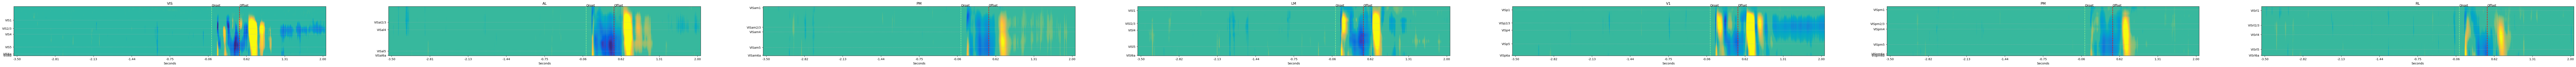

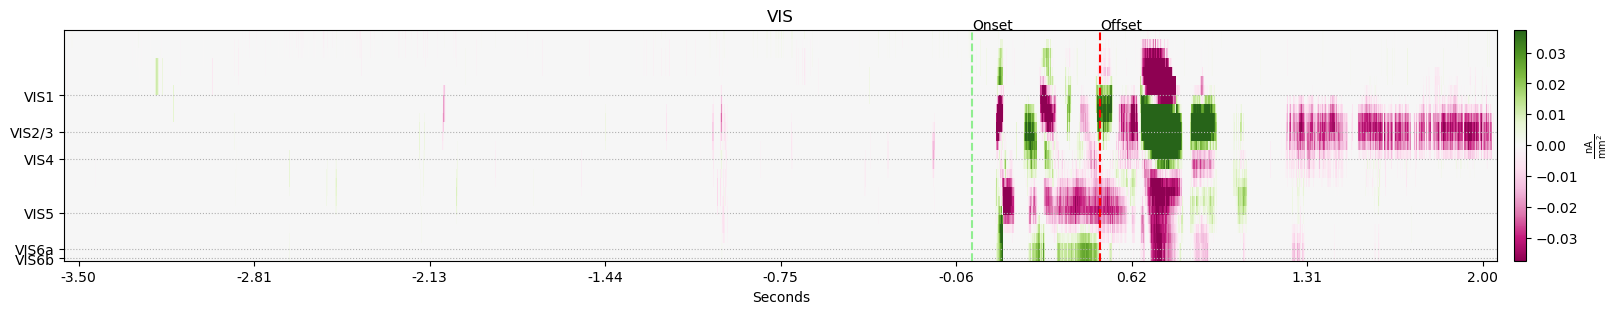

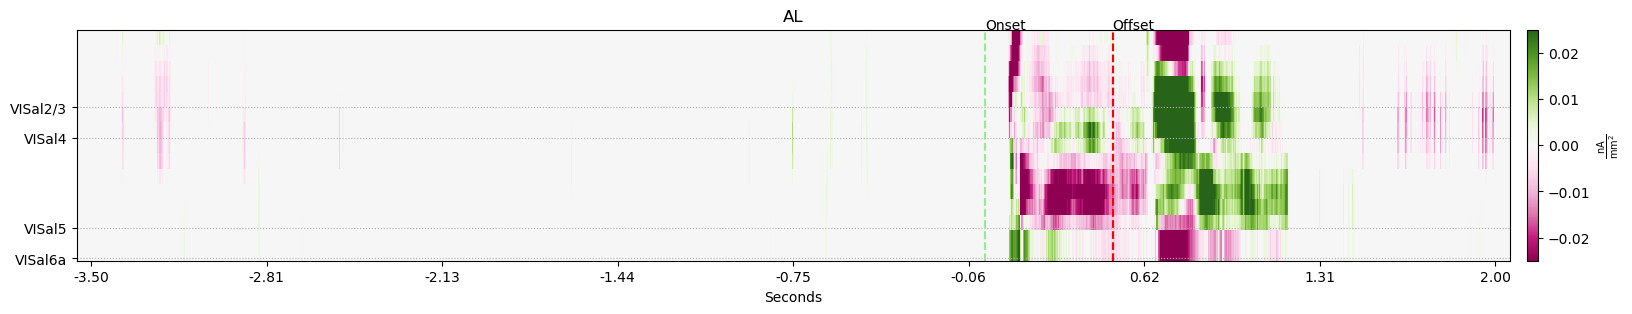

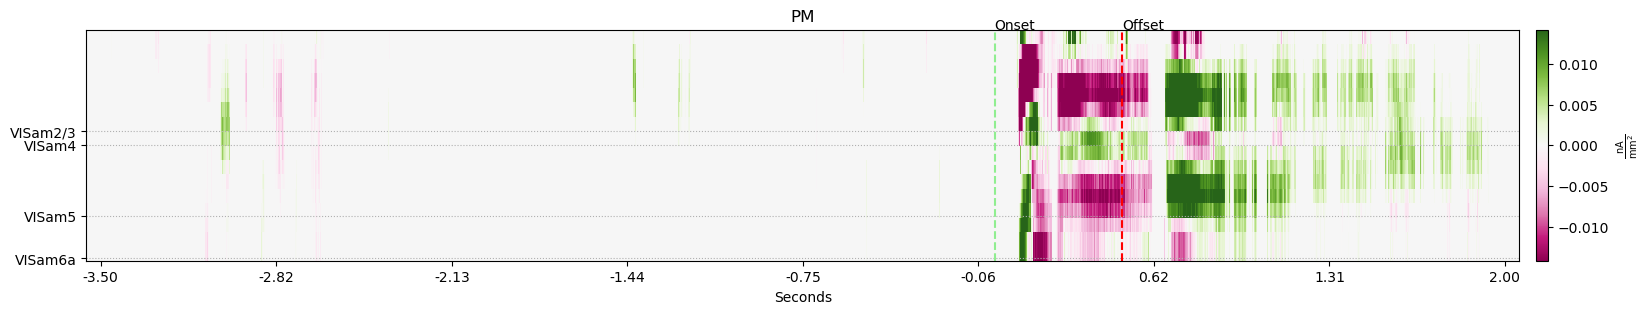

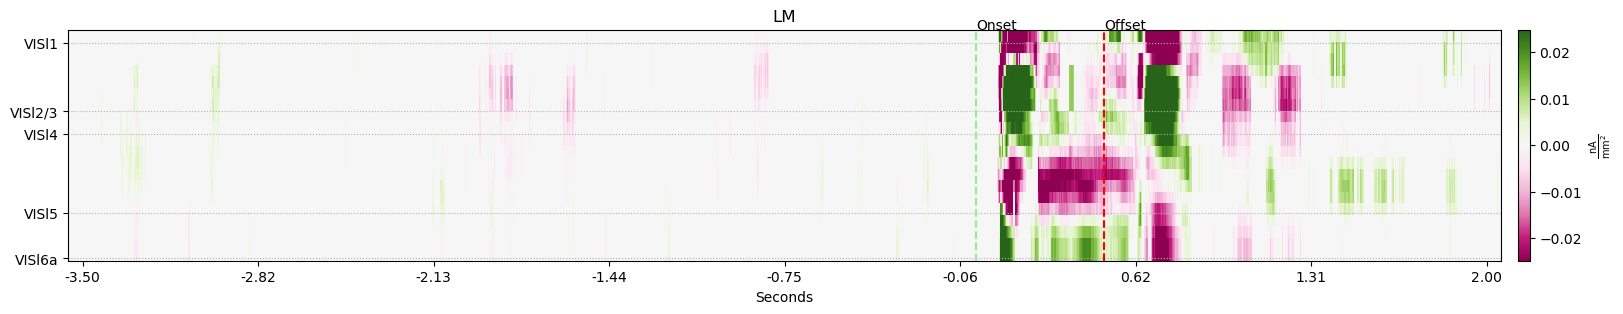

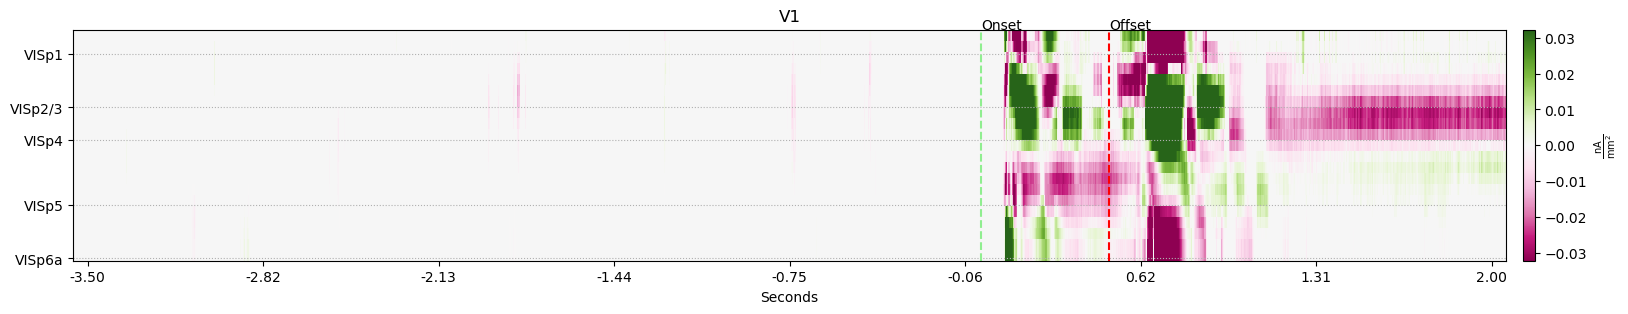

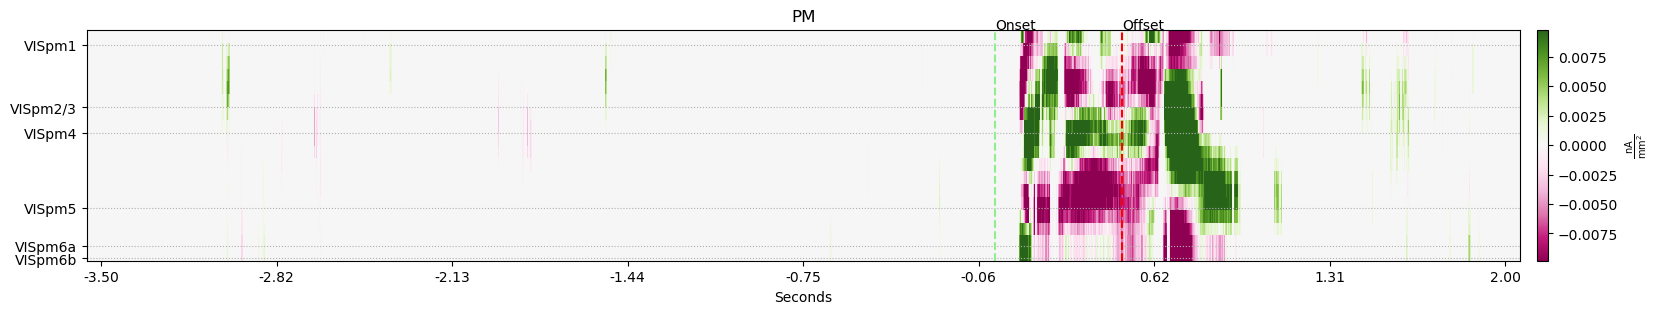

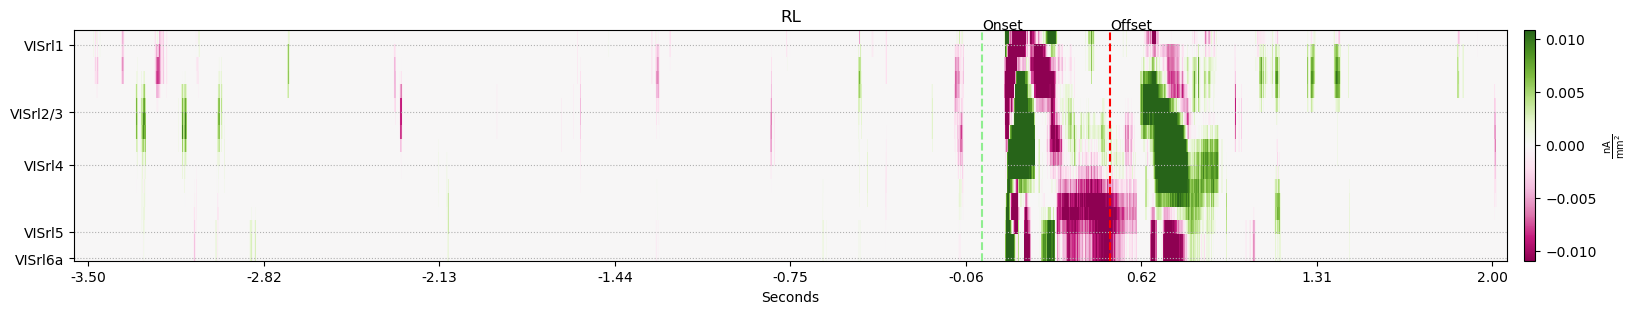

INFO:root:Plotted grand t-test contrasts for logo


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

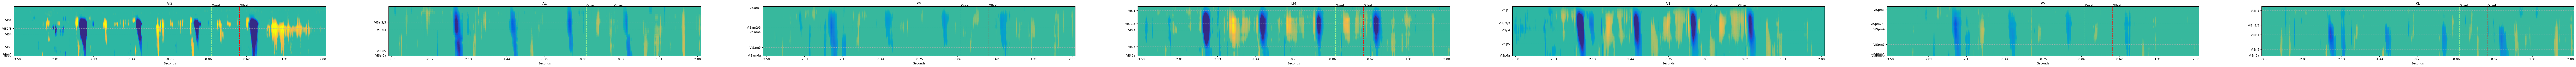

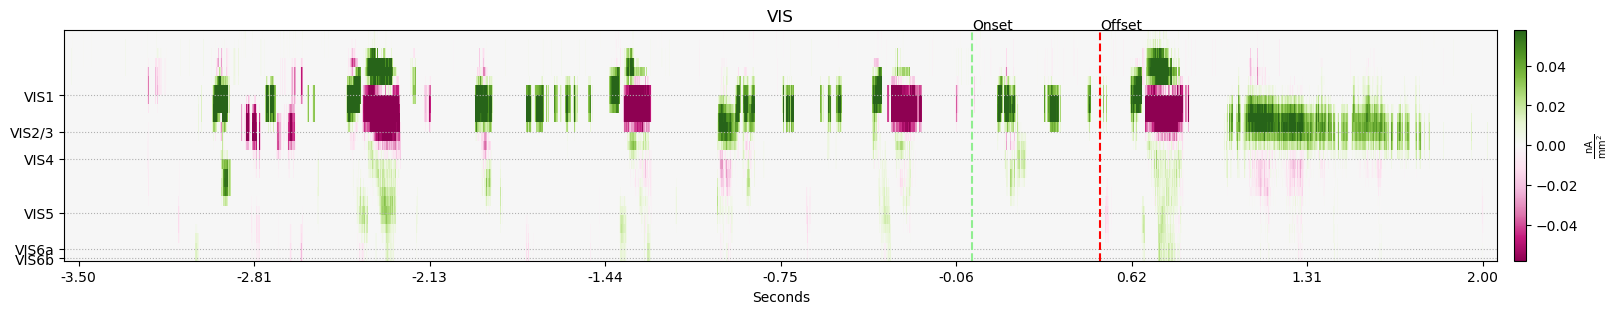

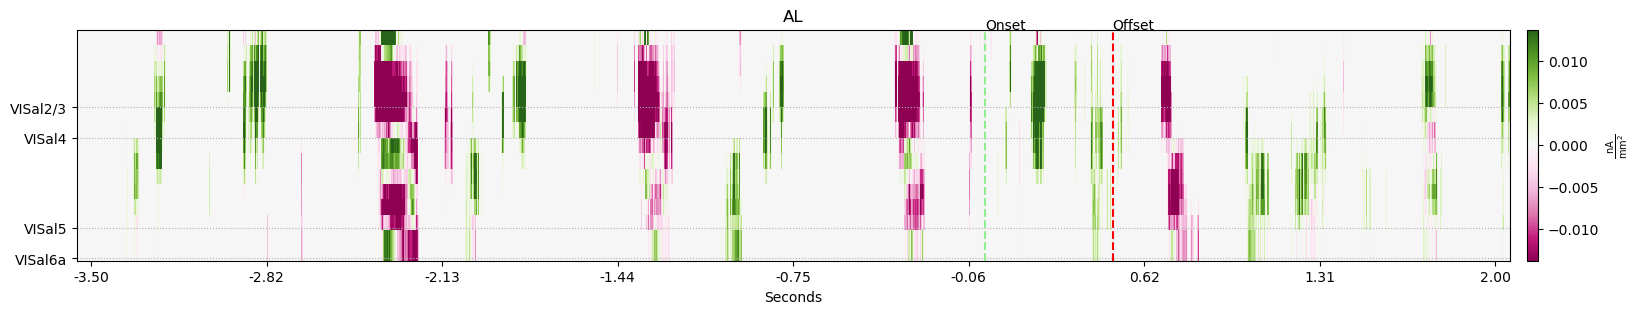

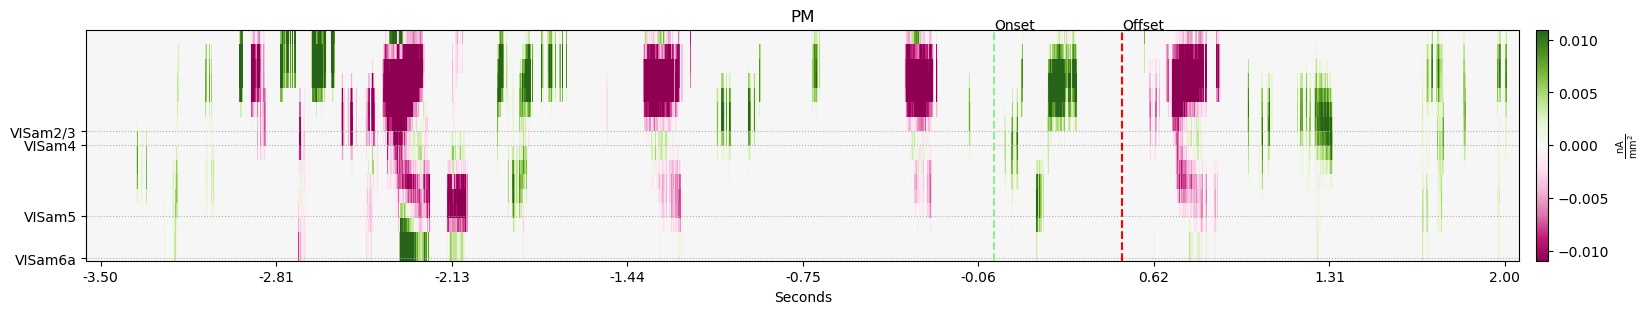

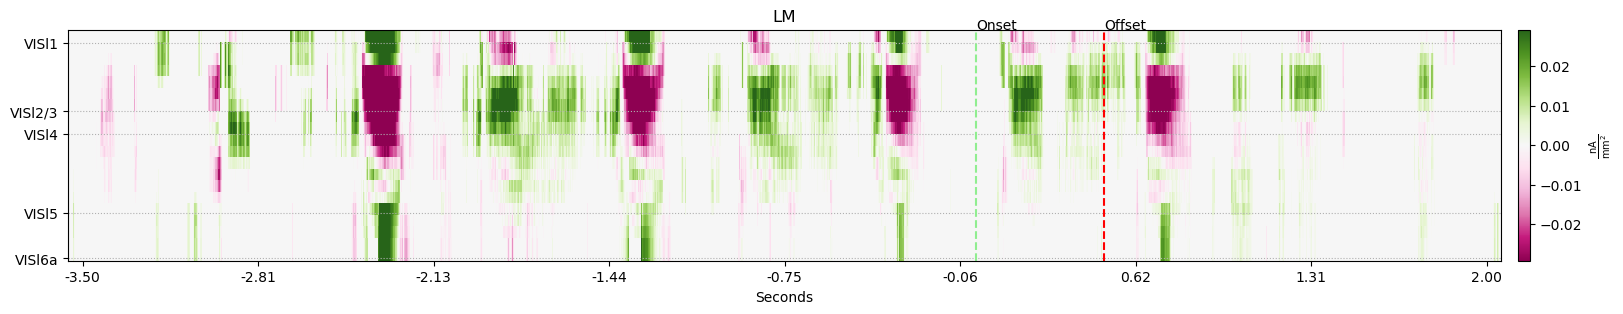

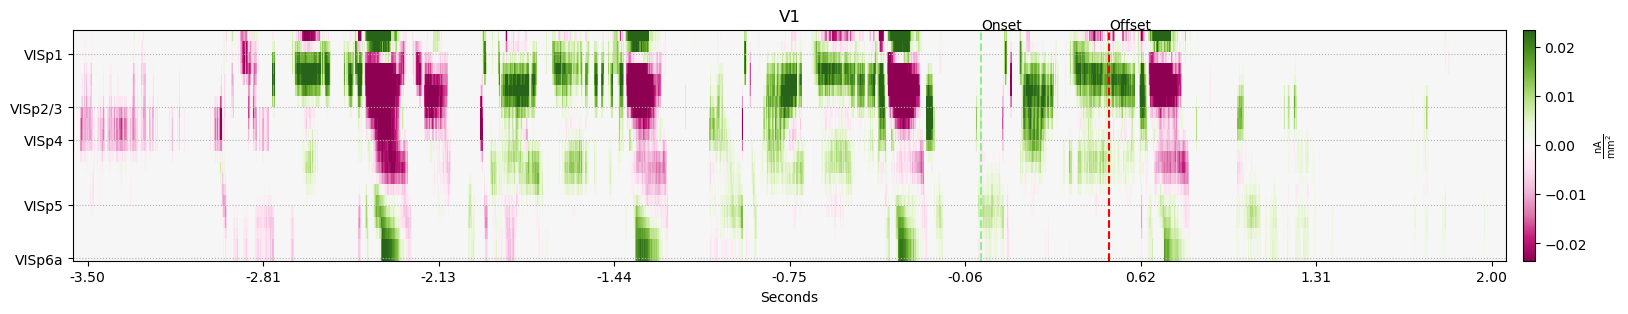

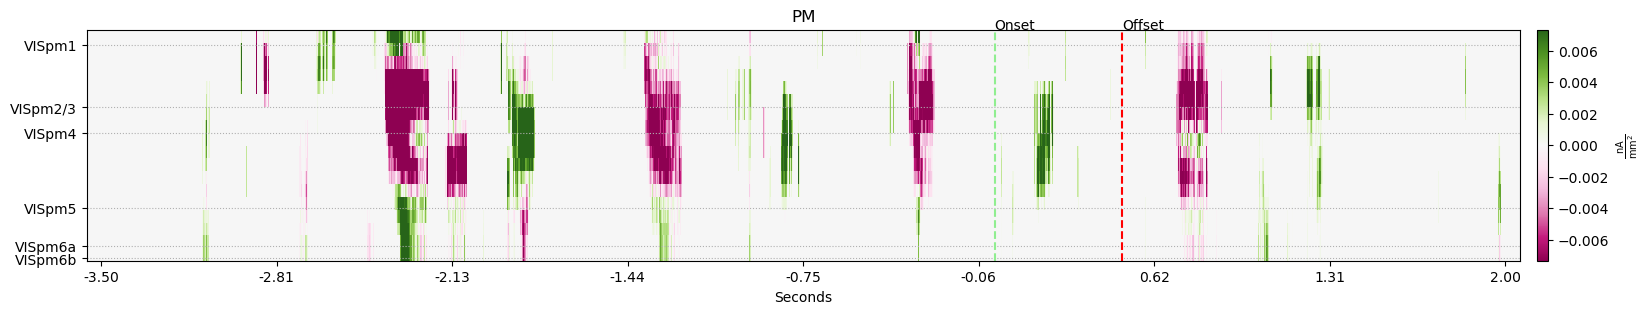

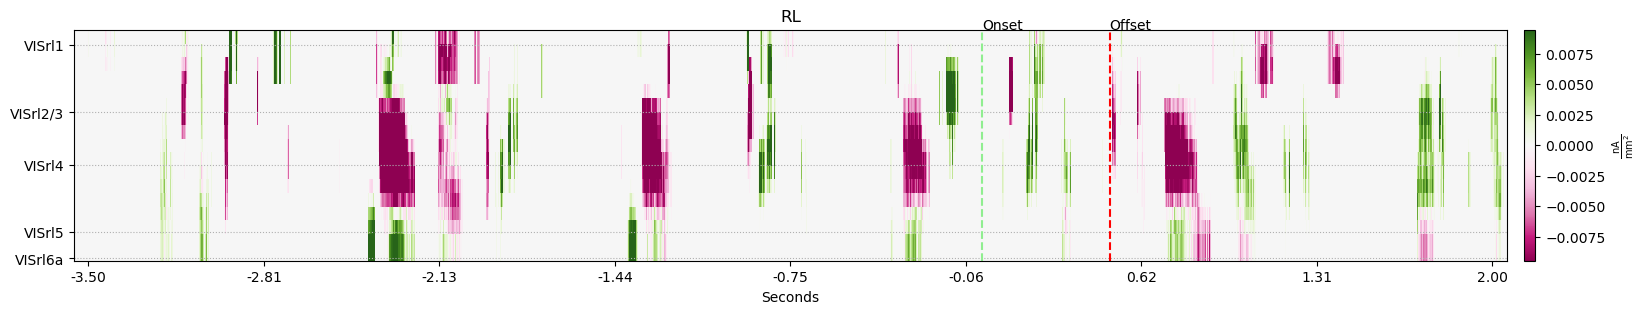

INFO:root:Plotted grand t-test contrasts for go_contrast


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

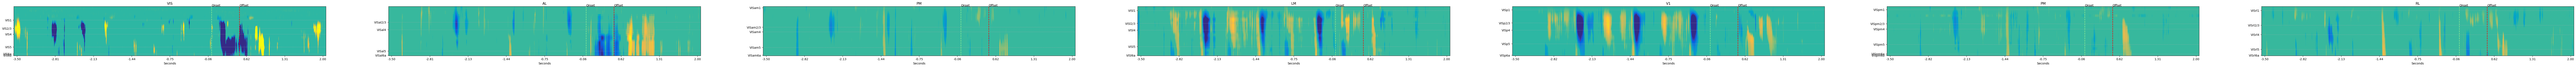

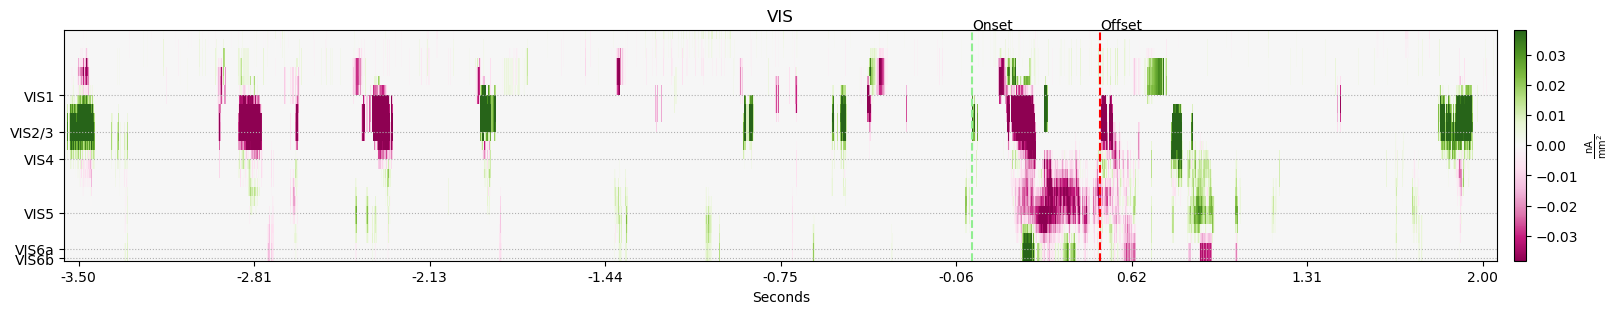

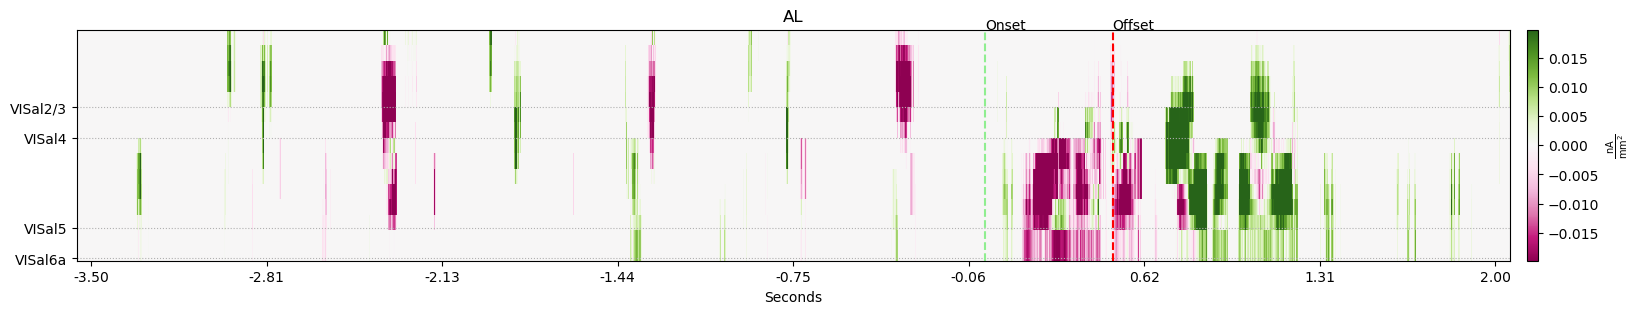

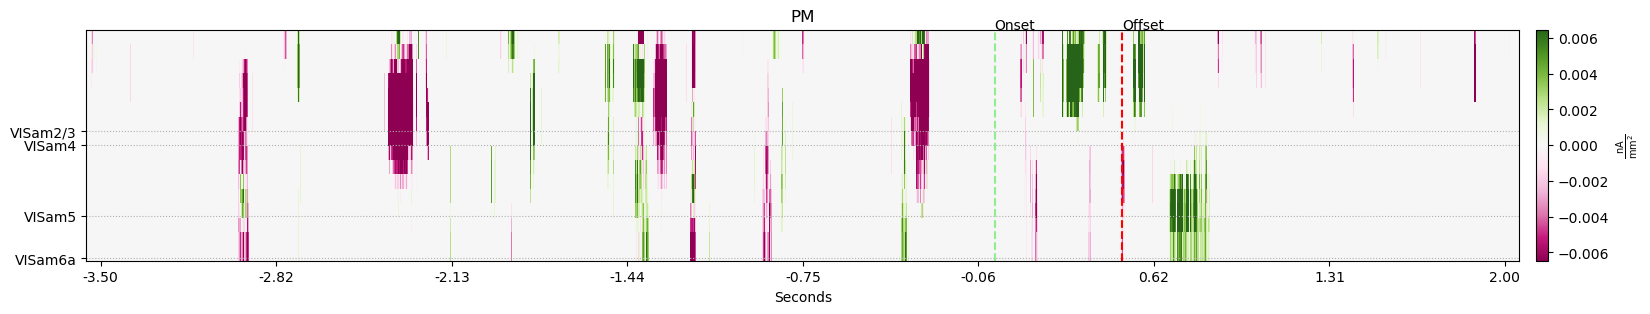

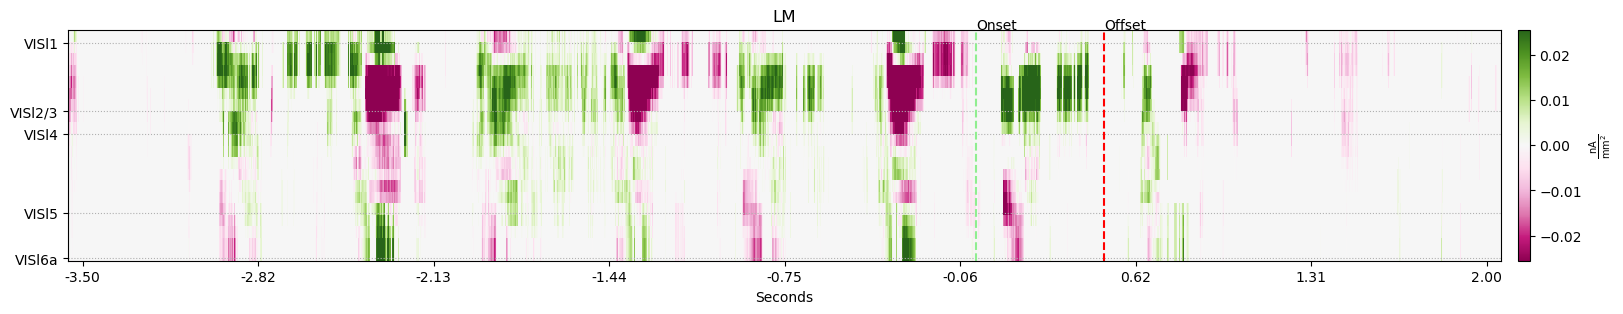

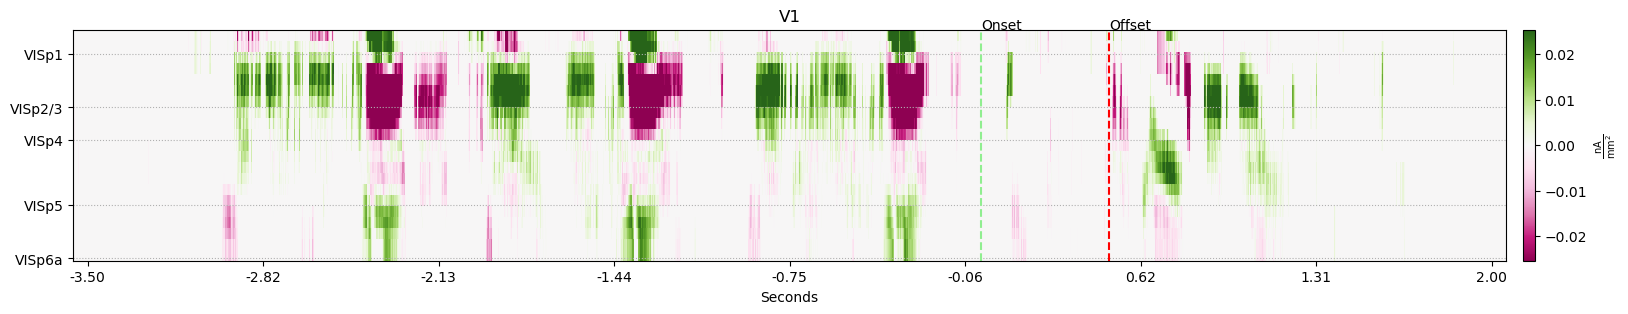

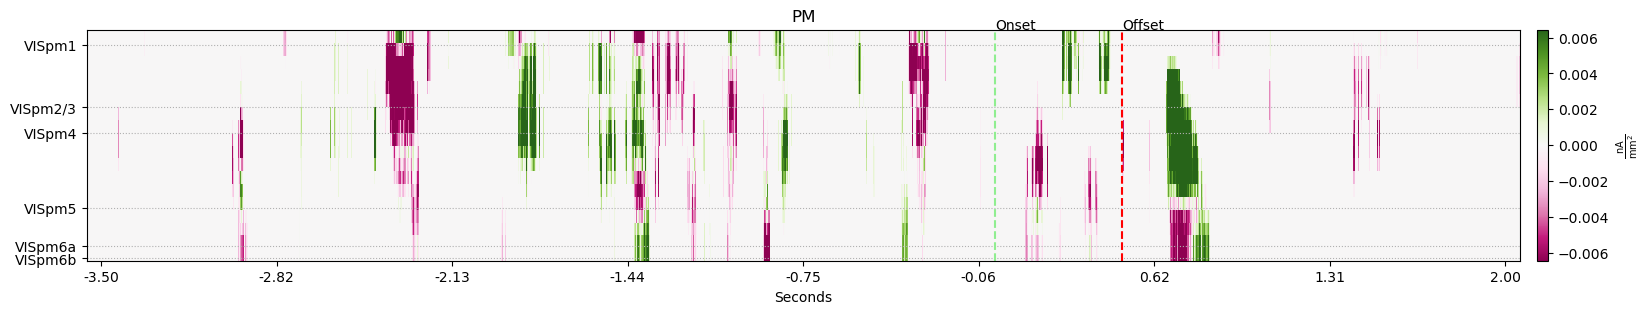

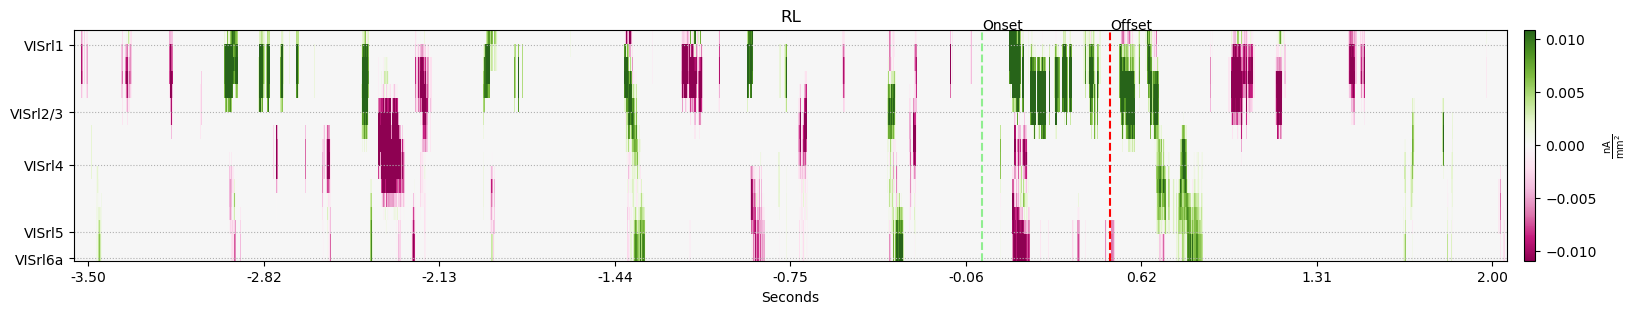

INFO:root:Plotted grand t-test contrasts for lo_contrast


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

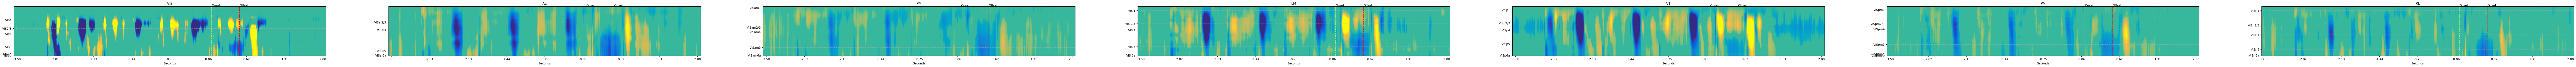

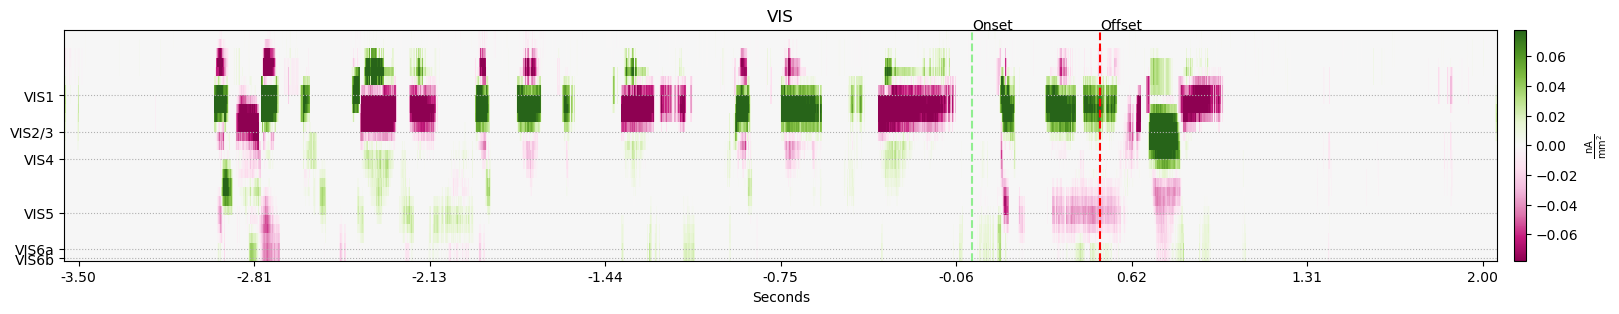

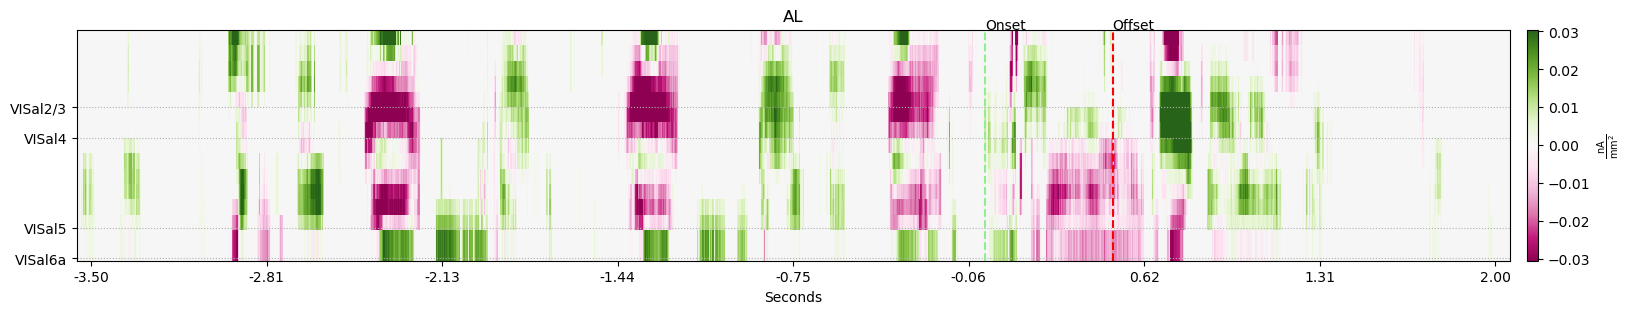

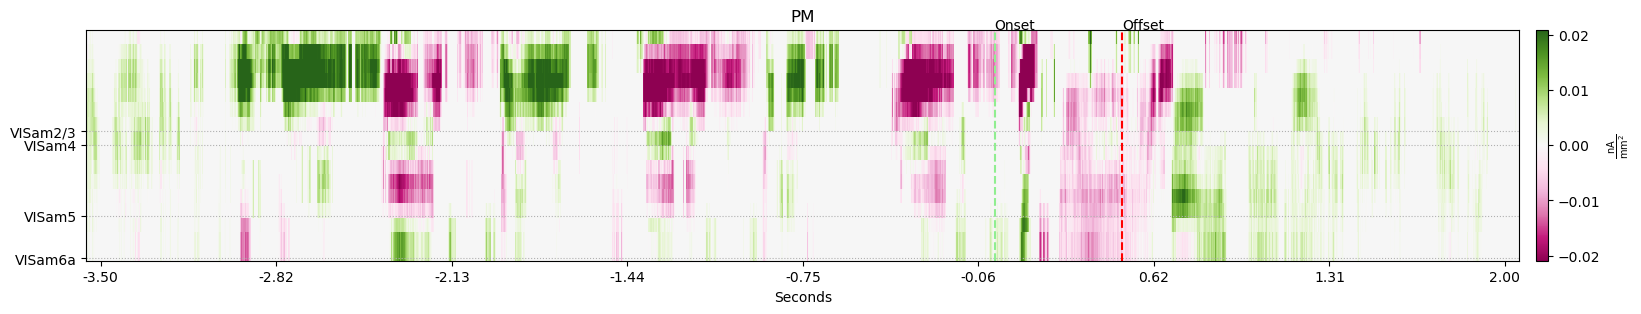

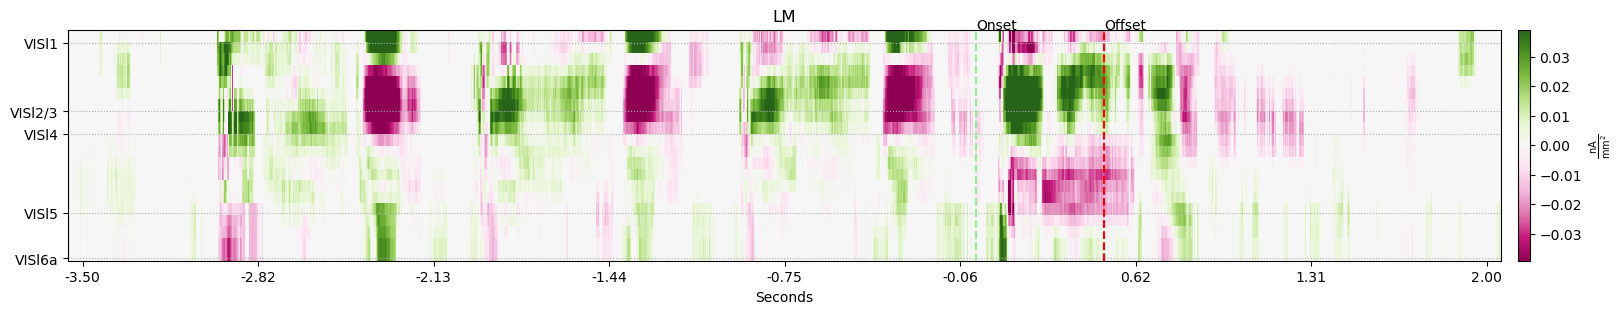

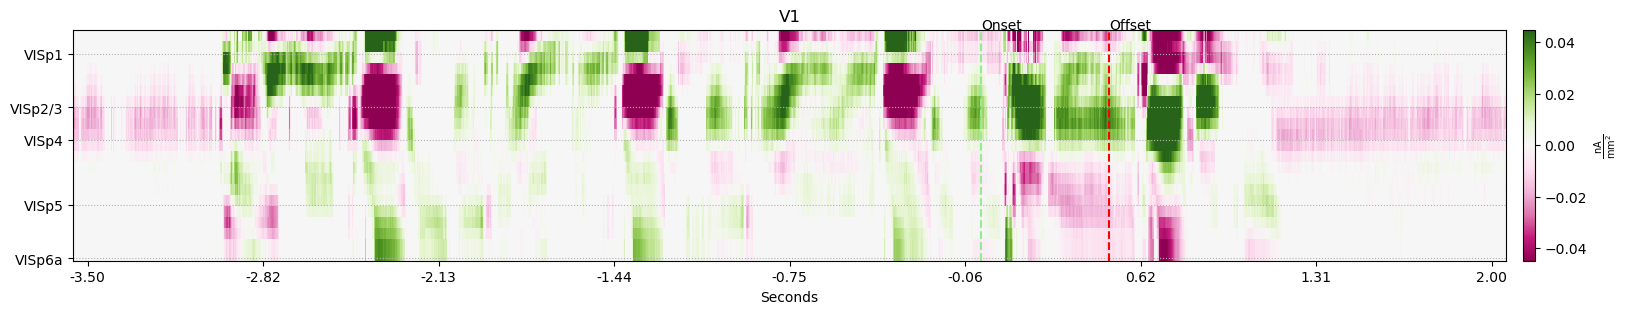

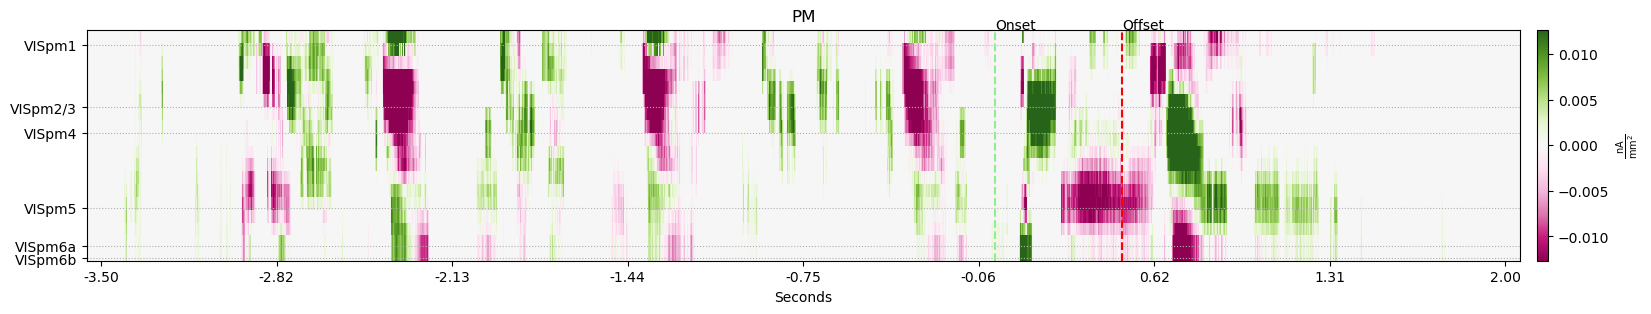

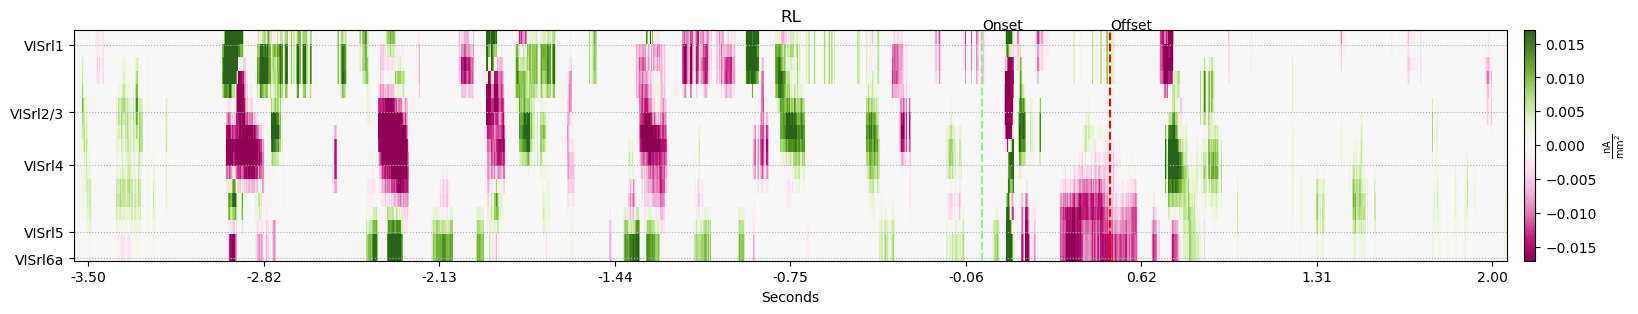

INFO:root:Plotted grand t-test contrasts for ssa


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

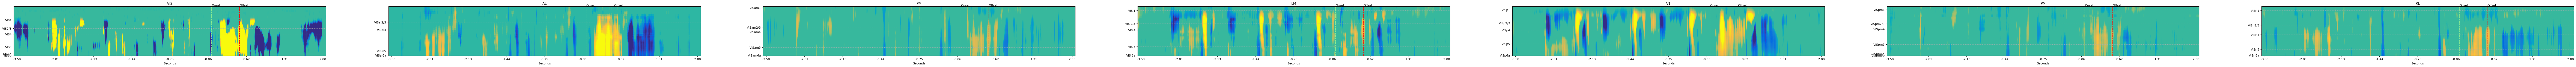

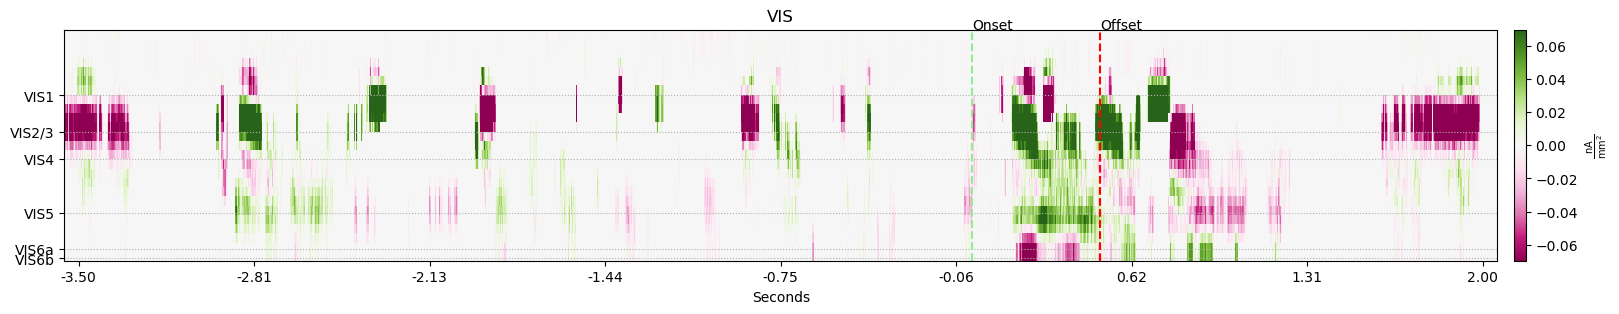

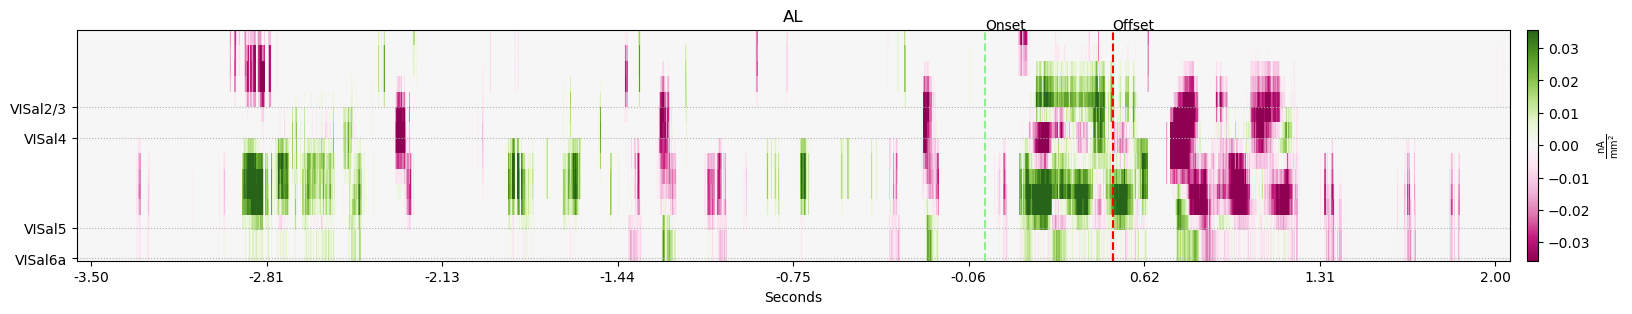

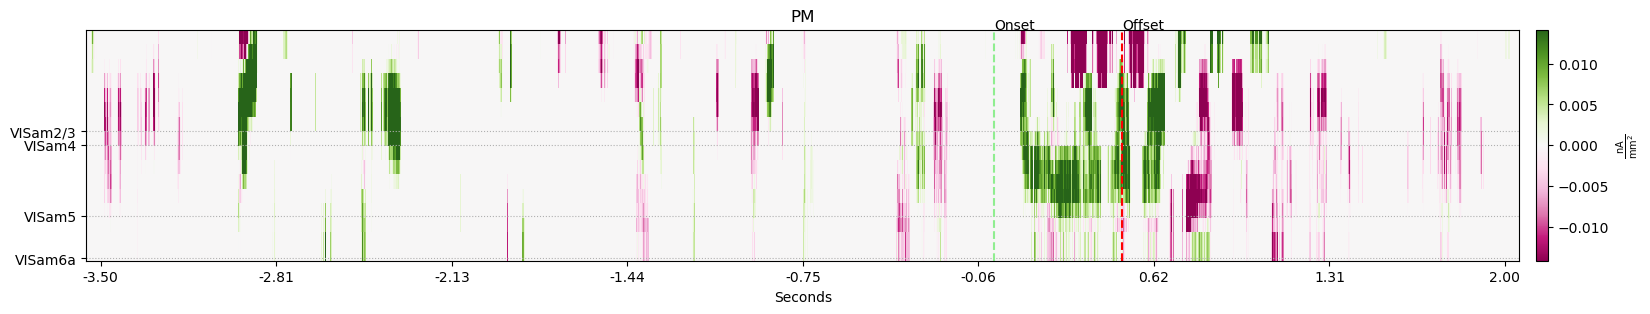

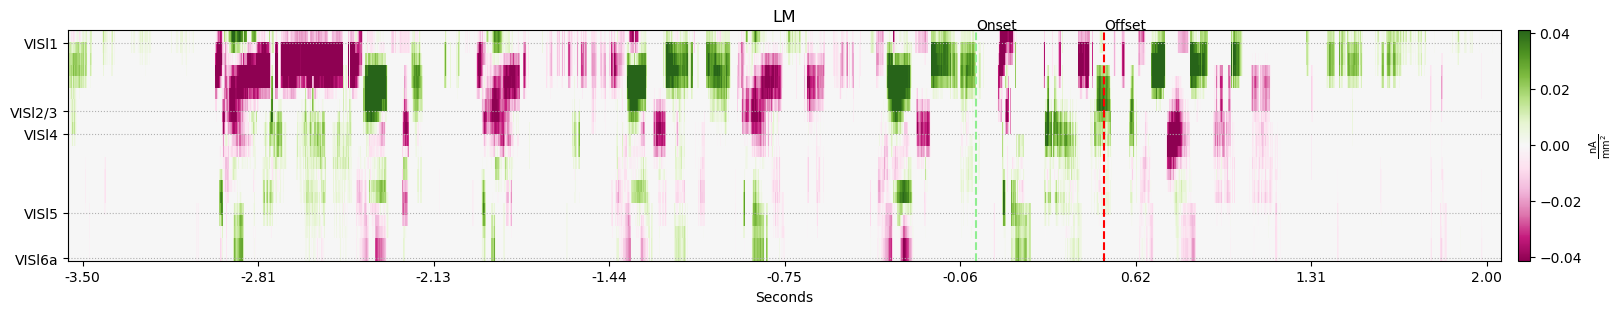

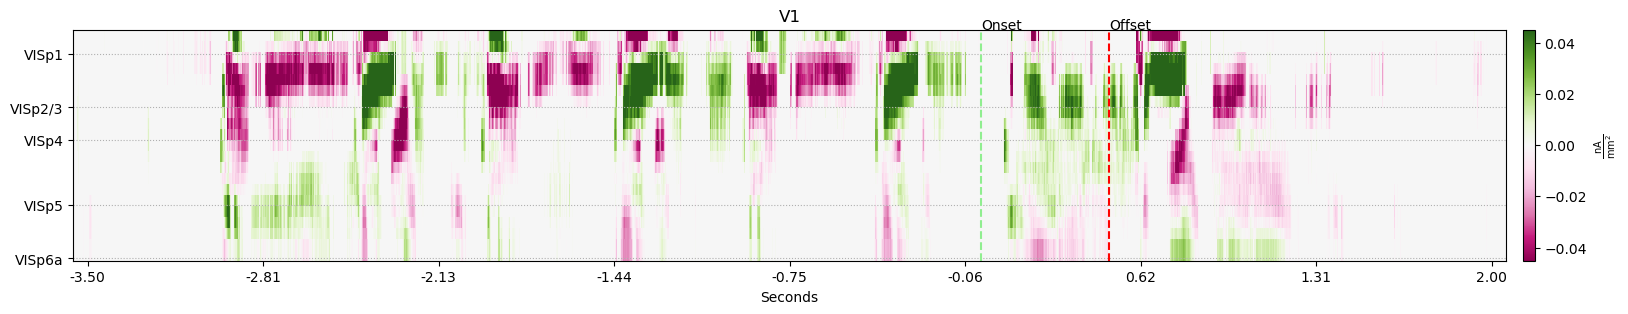

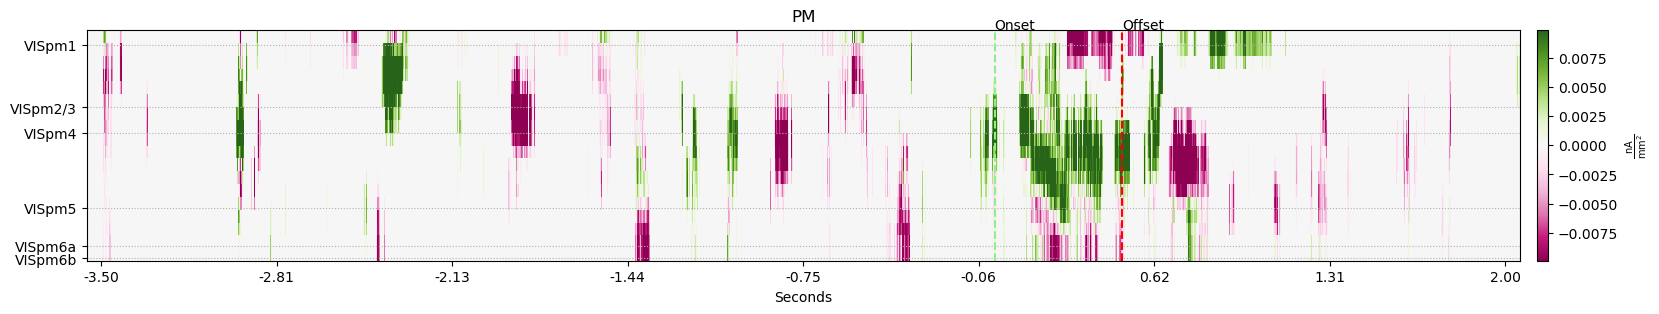

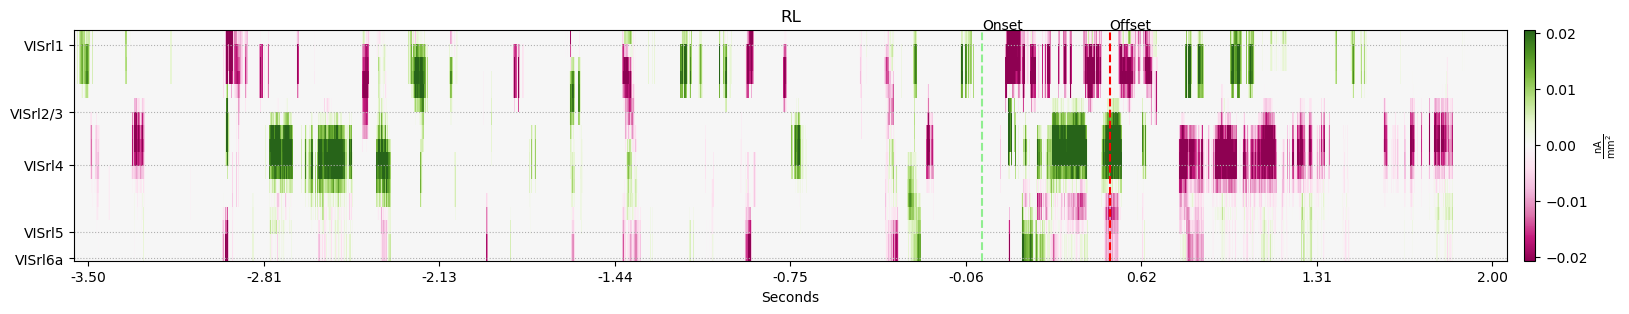

INFO:root:Plotted grand t-test contrasts for dd


In [19]:
for (contrast, condl, condr) in CONTRASTS:
    plot_contrast(contrast, condl, condr)
    logging.info("Plotted grand t-test contrasts for %s" % contrast)

In [20]:
OFFSET = np.array(0.25) * pq.second

def subtraction_variance(cond_summary):
    result = cond_summary.__class__(cond_summary.signal_key, cond_summary.stat)
    for area, grand_var in cond_summary.stats.items():
        alignment = grand_var.alignment
        mean, variance = grand_var.mean, grand_var.result()
        mean_subtraction = mean[(ODDBALL_ONSET - OFFSET).magnitude:(ODDBALL_OFFSET + OFFSET).magnitude] - mean[(ADAPTED_ONSET - OFFSET).magnitude:(ADAPTED_OFFSET + OFFSET).magnitude]
        mean_subtraction = mean_subtraction.shift_timestamps(-OFFSET)
        variance_addition = variance[(ODDBALL_ONSET - OFFSET).magnitude:(ODDBALL_OFFSET + OFFSET).magnitude] + variance[(ADAPTED_ONSET - OFFSET).magnitude:(ADAPTED_OFFSET + OFFSET).magnitude]
        variance_addition = variance_addition.shift_timestamps(-OFFSET)
        result._stats[area] = grand.GrandVariance(alignment, mean_subtraction)
        result.stats[area].data["diffs"] = variance_addition.data * (grand_var.data["n"] - 1)
        result.stats[area].data["k"] = grand_var.data["k"]
        result.stats[area].data["n"] = grand_var.data["n"]
    return result

In [21]:
CONTRAST_STDS = {}

In [22]:
def compute_subtraction_contrast(name, condl, condr):
    summaryl = subtraction_variance(summaries[condl])
    summaryr = subtraction_variance(summaries[condr])
    contrast = epych.statistics.grand.summary_t_test(summaryl, summaryr)
    lfp_diffs, csd_diffs = {}, {}
    for area in sorted(contrast.keys()):
        meanl, meanr = summaryl.stats[area].mean, summaryr.stats[area].mean
        diff_data = (meanl.data - meanr.data) * (contrast[area][1] < PVALUE)
        lfp_diffs[area] = epych.signals.lfp.EvokedLfp(meanl.channels, diff_data, meanl.dt, meanl.times)

        csdl, csdr = meanl.downsample(4).current_source_density(depth_column="vertical"), meanr.downsample(4).current_source_density(depth_column="vertical")
        csdl._data, csdr._data = csdl.data.rescale('nA / mm**2'), csdr.data.rescale('nA / mm**2')
        diff_data = (csdl.data - csdr.data) * (contrast[area][1][::4, :, :] < PVALUE)
        if name not in CONTRAST_STDS:
            CONTRAST_STDS[name] = {}
        CONTRAST_STDS[name][area] = diff_data.std()
        csd_diffs[area] = epych.signals.lfp.EvokedLfp(meanl.channels[::4], diff_data, meanl.dt, meanl.times)

    lfps = epych.recording.EvokedSampling(epych.recording.empty_intervals(), epych.recording.empty_trials(), epych.recording.default_units(),
                                          **lfp_diffs)
    csds = epych.recording.EvokedSampling(epych.recording.empty_intervals(), epych.recording.empty_trials(), epych.recording.default_units(),
                                          **csd_diffs)
    return contrast, lfps, csds

In [23]:
def plot_subtraction_contrast(name, condl, condr):
    contrast, lfps, csd = compute_subtraction_contrast(name, condl, condr)
    lfps.plot(vmin=-1e-1, vmax=1e-1, figure=name + "_4minus3_all_lfps.svg", sigtitle=sigtitle, **EVENTS)
    csd.plot_signals(name + "_4minus3_significant", vmaxs={area: 2 * std_dev for area, std_dev in CONTRAST_STDS[name].items()}, vmins={area: -2 * std_dev for area, std_dev in CONTRAST_STDS[name].items()},
                     sigtitle=sigtitle, cmap='PiYG', **EVENTS)

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

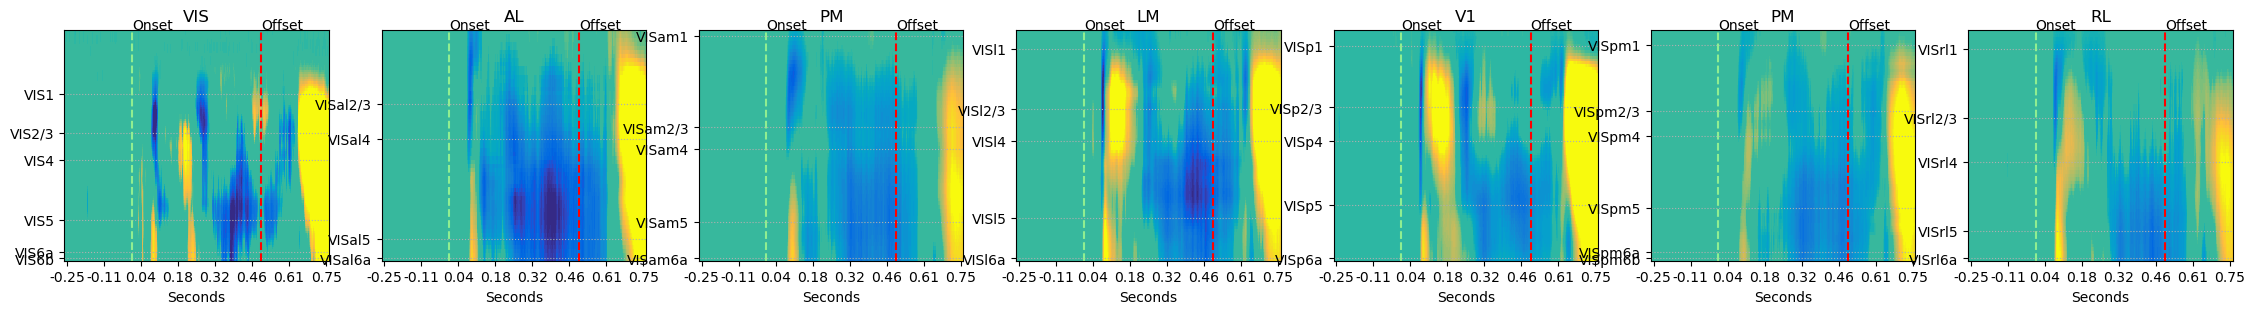

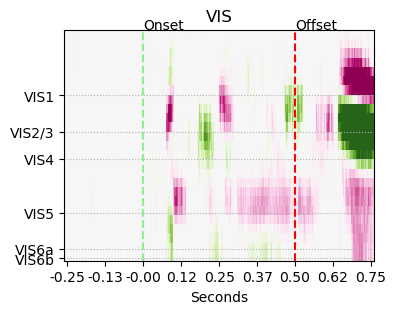

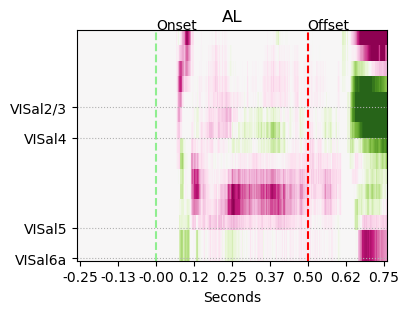

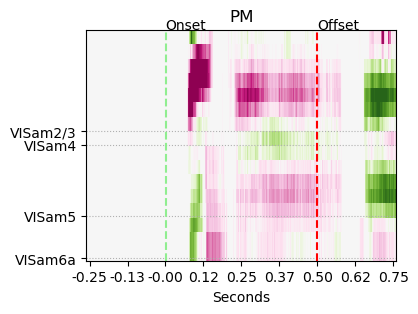

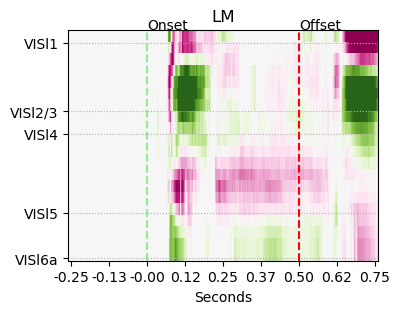

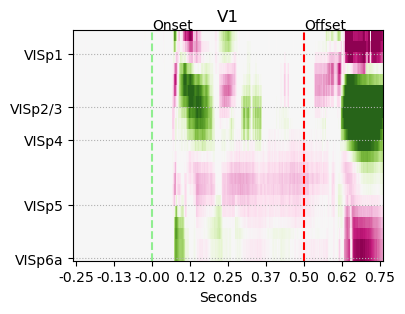

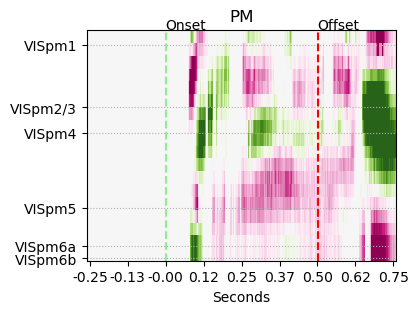

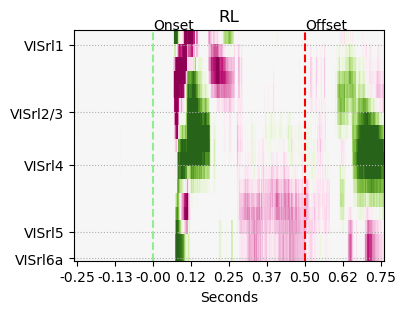

INFO:root:Plotted grand t-test of 4th-minus-3rd contrasts for logo


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

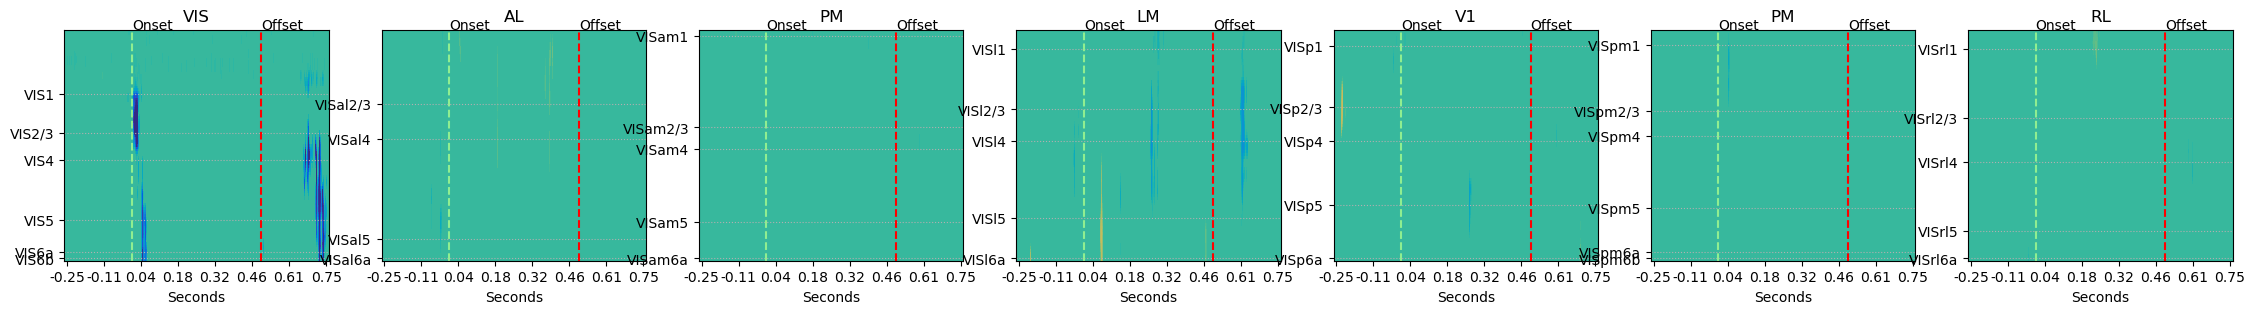

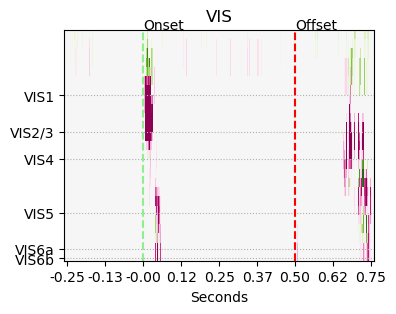

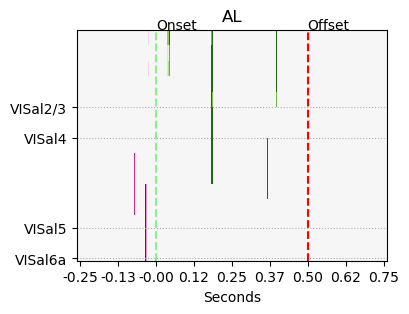

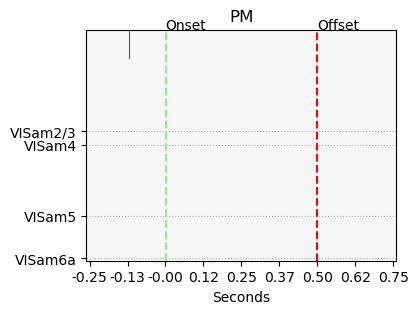

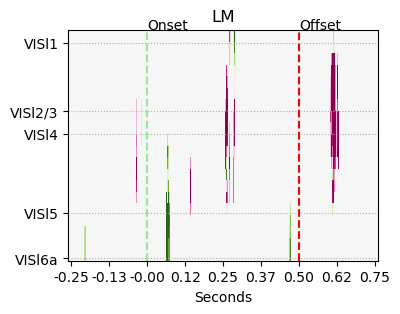

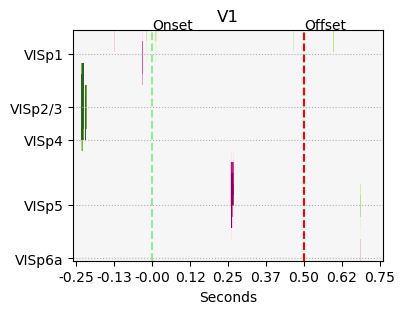

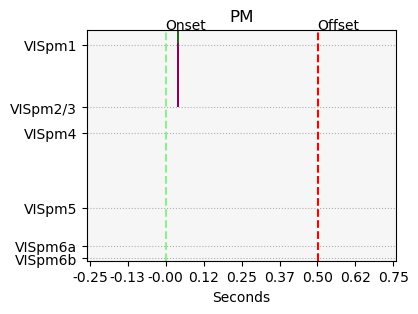

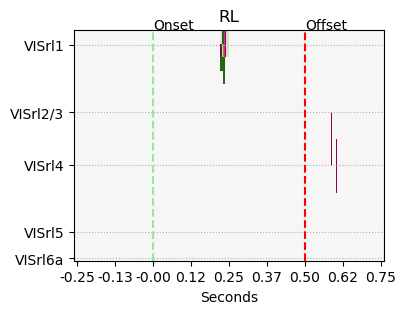

INFO:root:Plotted grand t-test of 4th-minus-3rd contrasts for go_contrast


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

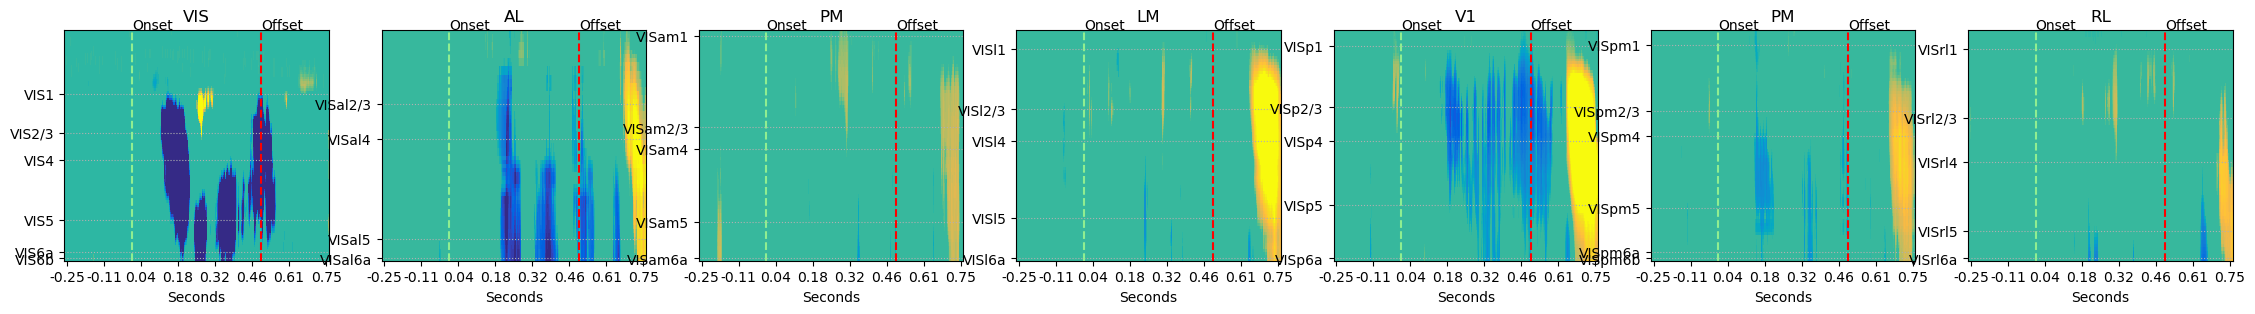

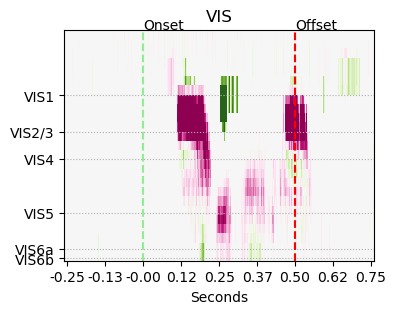

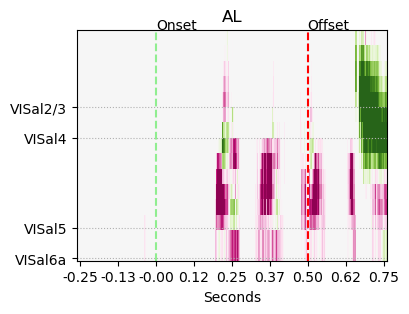

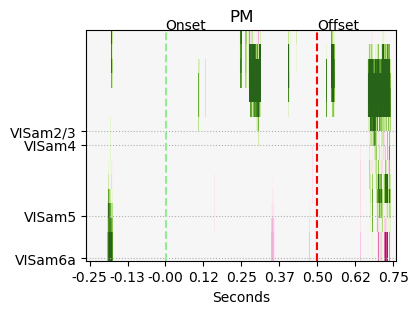

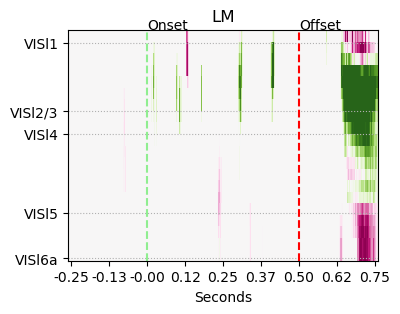

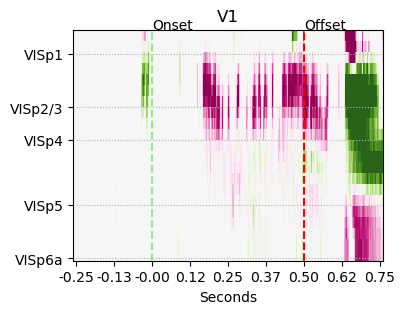

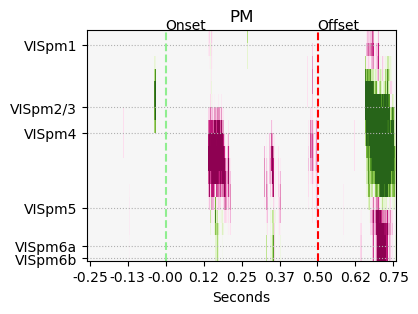

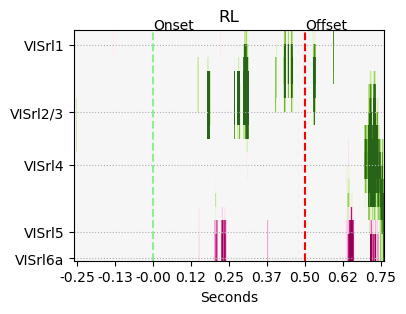

INFO:root:Plotted grand t-test of 4th-minus-3rd contrasts for lo_contrast


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

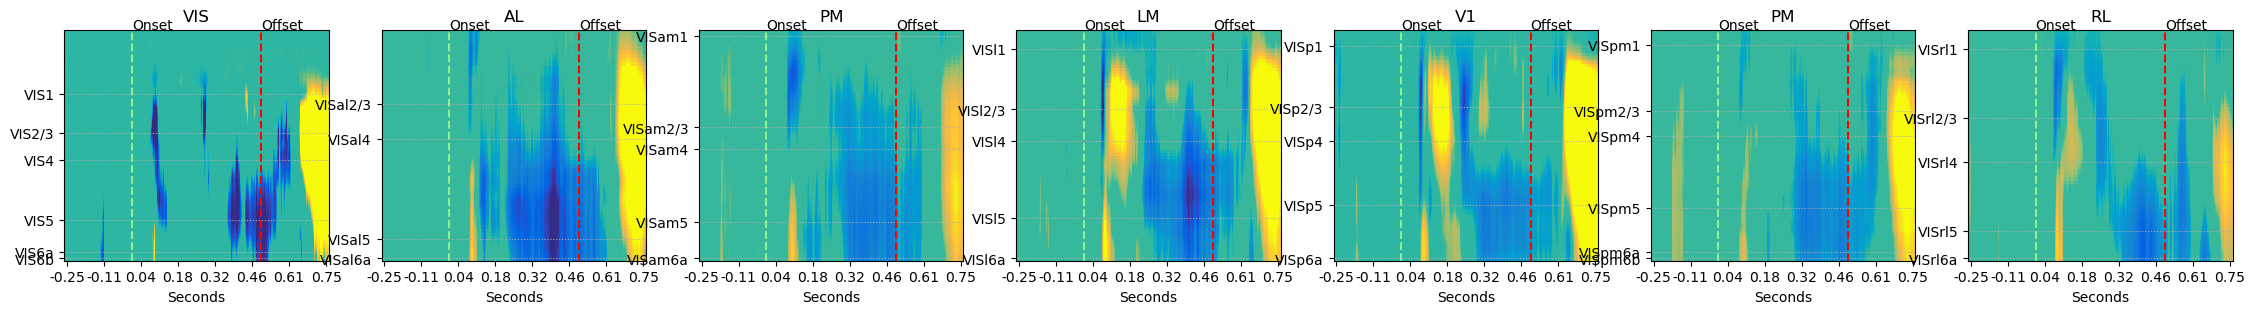

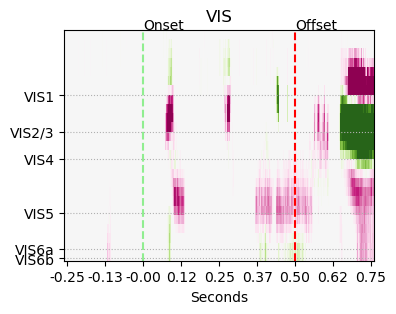

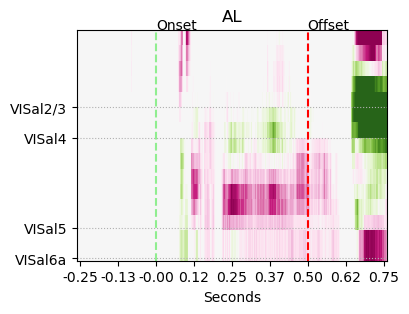

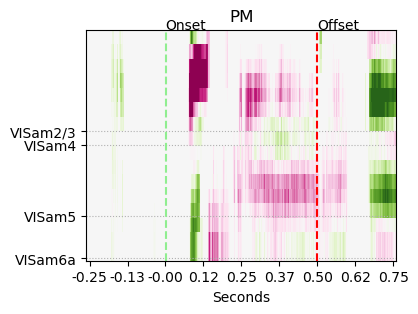

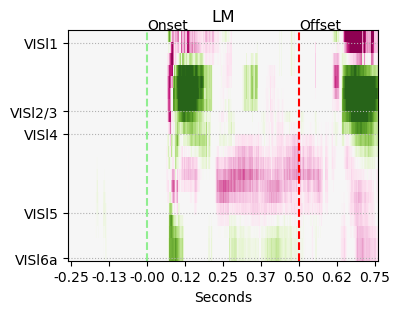

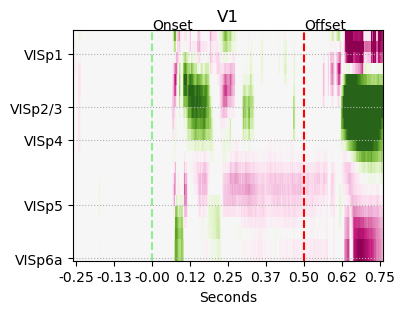

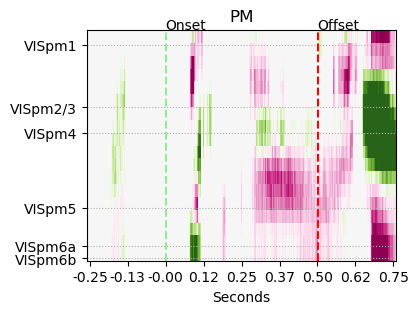

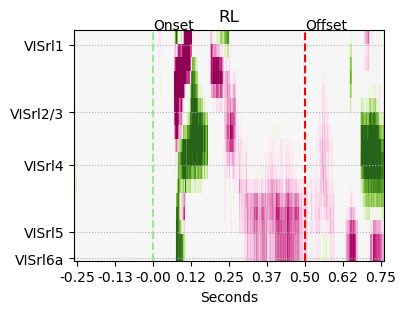

INFO:root:Plotted grand t-test of 4th-minus-3rd contrasts for ssa


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

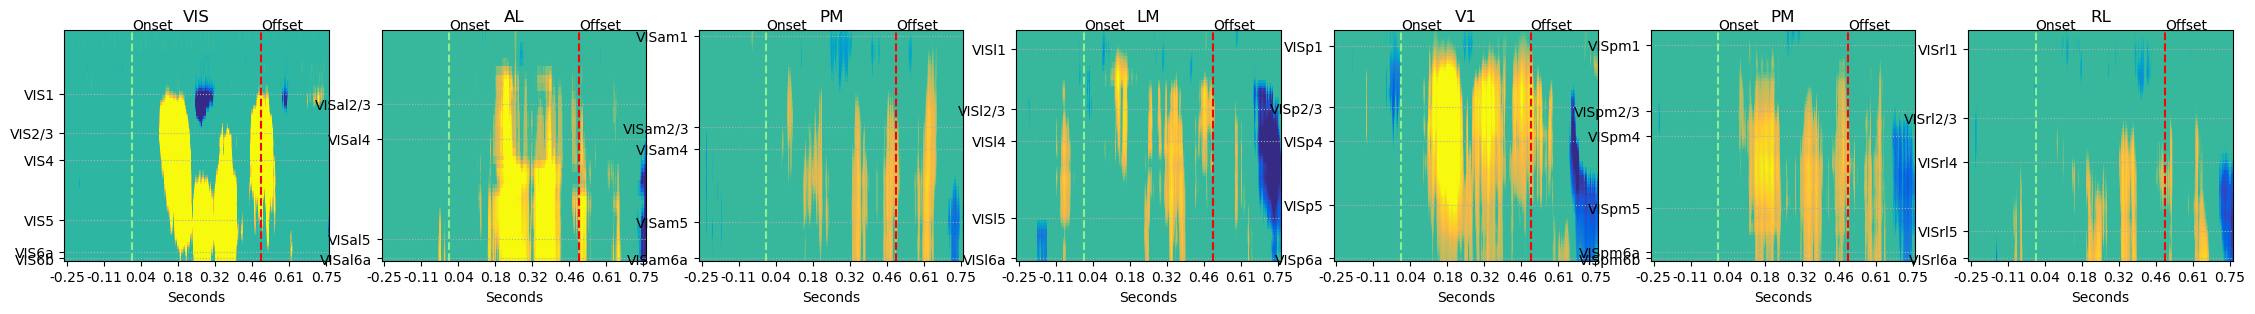

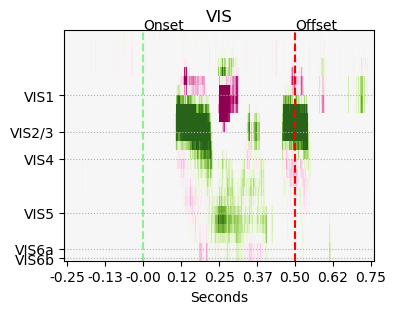

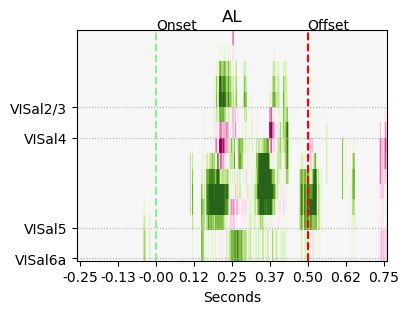

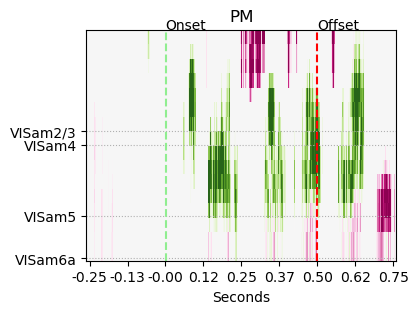

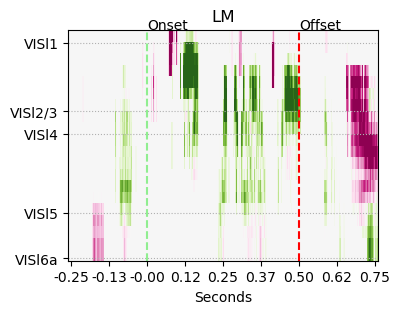

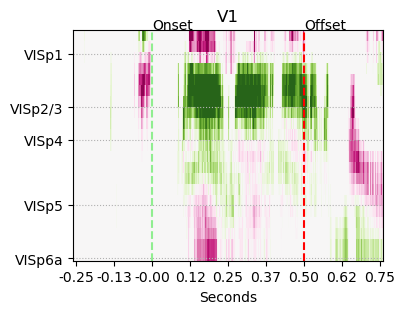

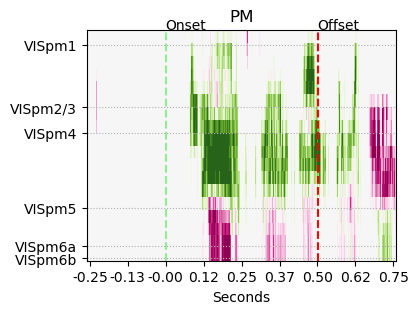

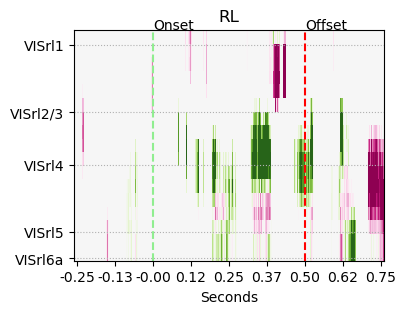

INFO:root:Plotted grand t-test of 4th-minus-3rd contrasts for dd


In [24]:
for (contrast, condl, condr) in CONTRASTS:
    plot_subtraction_contrast(contrast, condl, condr)
    logging.info("Plotted grand t-test of 4th-minus-3rd contrasts for %s" % contrast)